In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
import SpectralEvents.spectralevents as se
import matplotlib.animation as animation
from tfr_utils import compute_tfr
%matplotlib inline

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [3]:
SESSIONS = [766640955, 768515987, 778240327, 821695405, 835479236, 839068429, 839557629]

In [4]:
# load project cache
manifest_path = f"../data/allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json"
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [5]:
# # import behavior projet cache class from SDK to be able to load the data
# from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# # if we needed to download the data we could have used the following line
# # cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [6]:
# get the metadata tables
# units_table = cache.get_unit_table()

channels_table = cache.get_channels()

ecephys_sessions_table = cache.get_session_table()

probes = cache.get_probes()
valid_lfp = probes[probes['has_lfp_data']]

print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9789156626506024


In [7]:
session_id = SESSIONS[0]
filtered_probes = probes[probes['ecephys_session_id'] == session_id]
for name in filtered_probes[['name', 'ecephys_structure_acronyms']].values:
    print(name)

['probeA'
 array(['MB', 'APN', 'NOT', 'DG', 'CA1', 'VISam', nan], dtype=object)]
['probeB'
 array(['PF', 'TH', 'LP', 'MB', 'APN', 'DG', 'CA1', 'VISmma', nan],
       dtype=object)                                               ]
['probeC' array(['LP', 'DG', 'CA1', 'VISp', nan], dtype=object)]
['probeD'
 array(['MGd', 'TH', 'DG', 'CA3', 'CA1', 'VISl', nan], dtype=object)]
['probeE'
 array(['VPM', 'TH', 'LGd', 'CA3', 'DG', 'CA1', 'VISal', nan], dtype=object)]
['probeF' array(['MB', 'APN', 'DG', 'CA1', 'VISrl', nan], dtype=object)]


In [8]:
filtered_probes = filtered_probes[filtered_probes['name'] == 'probeE']
probe_id = filtered_probes.index.values[0]
filtered_probes

,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,unit_count,channel_count,ecephys_structure_acronyms
id,,,,,,,,,
773592328,766640955,1250.000054,probeE,3a,30000.001302,True,223,373,"[VPM, TH, LGd, CA3, DG, CA1, VISal, nan]"


In [9]:
session = cache.get_session_data(session_id=session_id)


/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [10]:
lfp = session.get_lfp(probe_id)

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [11]:
def window_lfp(lfp, alignment_window, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([alignment_window])
    
    if trial_ids is None:
        trial_ids = [1]
        
    # inds = pd.MultiIndex.from_product((trial_ids, alignment_window), 
    #                                   names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')

    return ds['aligned_lfp']

def apply_specparam(spectra, freqs, specparam_settings, n_jobs=-1):
    """
    Apply spectral parameterization to 3D array of power spectra.

    Parameters
    ----------
    spectra : 3d array
        Power spectra, with dimensions [n_spectra, n_freqs, n_times].
    freqs : 1d array
        Frequency values for the power spectra.
    specparam_settings : dict
        Settings for the spectral parameterization.
    n_jobs : int
        Number of parallel jobs to run.

    Returns
    -------
    exponent : 2d array
        Aperiodic exponents for each power spectrum. Dimensions are 
        [n_spectra, n_times].
    """
    
    # imports
    from specparam import SpectralGroupModel
    from specparam.objs import fit_models_3d, combine_model_objs
    
    spectra_rs = np.swapaxes(spectra, 1, 2) # make freq dimension last
    sm = SpectralGroupModel(**specparam_settings)
    # sm.set_check_data_mode(False)
    sgm = fit_models_3d(sm, freqs, spectra_rs, n_jobs=n_jobs)
    sgm = combine_model_objs(sgm)
    
    return sgm

In [12]:
stim_presentations = session.stimulus_presentations
spontaneous = stim_presentations[stim_presentations['stimulus_name'].str.contains('natural_movie')]
block_df = spontaneous[spontaneous['stimulus_block'] == 3]

spontaneous_times  = (np.min(block_df.start_time.values), np.max(block_df.stop_time.values))



/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [72]:
spont_window = np.arange(spontaneous_times[0], spontaneous_times[1], 1/500)
spont_lfp = window_lfp(lfp, spont_window).squeeze().T
spont_lfp['time'] = spont_lfp.time - spont_lfp.time.values[0]
spont_times = spont_lfp.time.values

In [73]:
chans = session.channels
chans = chans[~chans['structure_acronym'].isnull()]

chan_mask = np.isin(lfp.channel.values, chans.index.values)
spont_lfp = spont_lfp[chan_mask,:]

lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in spont_lfp.channel.values]
lfp_chan_names = [chans.loc[c]['structure_acronym'] for c in spont_lfp.channel.values]

region_names = np.unique(lfp_chan_names)
region_pos = list()
for name in region_names:
    region_chans = np.where(np.isin(lfp_chan_names, name))[0]
    region_pos.append(np.mean(region_chans))

region_pos = np.array(region_pos)
sorted_indices = np.argsort(region_pos)

region_pos = region_pos[sorted_indices][::-1]
region_names = region_names[sorted_indices][::-1]

color_dict = {name: f'C{idx}' for idx, name in enumerate(region_names)}
lfp_color_map = [color_dict[name] for name in lfp_chan_names]

chans_in_brain = chans[(chans['probe_id']==probe_id)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()

In [51]:
region_pos

array([66.5, 46. , 33.5, 26. , 14.5,  6. ,  2. ])

In [52]:
chan_idx_visp = 70
chan_idx_lgn = 10
print(lfp_chan_names[chan_idx_visp])
print(lfp_chan_names[chan_idx_lgn])

VISal
LGd


In [53]:
window_len = 500
t_idx = 0
bounds = range(t_idx, t_idx+window_len)
plot_times = spont_times[t_idx:t_idx+window_len]

In [54]:
spont_lfp[chan_idx_visp, :20_000].values.reshape(1, 1,-1).shape

(1, 1, 20000)

In [55]:
samp_freq = 500

# set parameters
freq_bounds = [1, 20, 50]  # fequency values (Hz) over which to calculate TFR
tfr_times = np.linspace(spont_lfp.time.values[0], spont_lfp.time.values[-1], len(spont_lfp.time.values))  # seconds
# tfrs = se.tfr(spont_lfp[chan_idx, :], freqs, samp_freq)
tfrs_visp, freqs = compute_tfr(spont_lfp[chan_idx_visp, :20_000].values.reshape(1, 1,-1), samp_freq, freqs=freq_bounds, freq_spacing='lin')
tfrs_lgn, freqs = compute_tfr(spont_lfp[chan_idx_lgn, :20_000].values.reshape(1, 1,-1), samp_freq, freqs=freq_bounds, freq_spacing='lin')

freq_mask = np.logical_and(freqs > 1, freqs < 10)
envelope_visp = np.sum(tfrs_visp[0, 0, freq_mask, :], axis=0)
envelope_lgn = np.sum(tfrs_lgn[0, 0, freq_mask, :], axis=0)

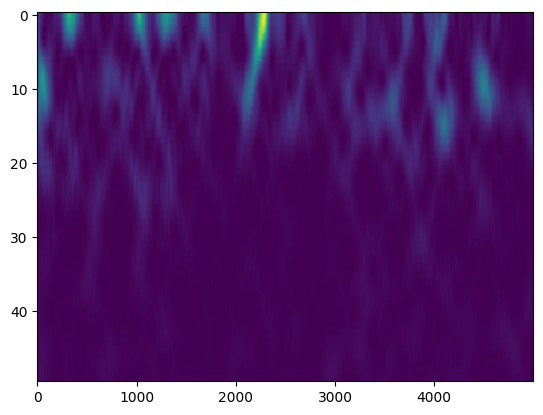

In [56]:
plt.imshow(tfrs_visp[0,0,:,:5000], aspect='auto')

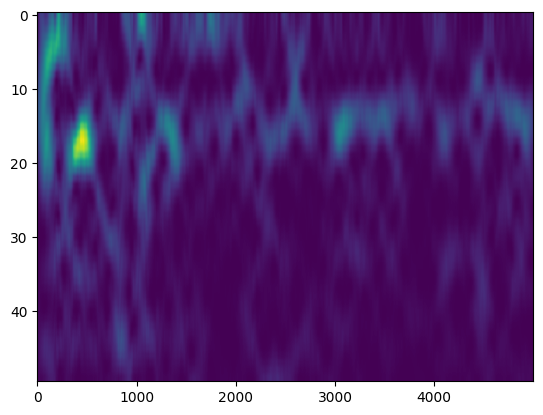

In [57]:
plt.imshow(tfrs_lgn[0,0,:,:5000], aspect='auto')

In [58]:
tfrs_visp.shape

(1, 1, 50, 20000)

In [59]:
# sgm_visp = apply_specparam(tfrs_visp[0,:,:,:20_000], freqs, specparam_settings={'peak_width_limits': [2, 20], 'aperiodic_mode': 'knee', 'verbose': False})
# sgm_lgn = apply_specparam(tfrs_lgn[0,:,:,:20_000], freqs, specparam_settings={'peak_width_limits': [2, 20], 'aperiodic_mode': 'knee', 'verbose': False})

# exponent_visp = sgm_visp.get_params('aperiodic', 'exponent')
# np.save('../results/exponent_visp_animation.npy', exponent_visp)

# exponent_lgn = sgm_lgn.get_params('aperiodic', 'exponent')
# np.save('../results/exponent_lgn_animation.npy', exponent_lgn)

exponent_visp = np.load('../results/exponent_visp_animation.npy')
exponent_lgn = np.load('../results/exponent_lgn_animation.npy')

In [60]:
# plt.plot(sgm.get_params('aperiodic', 'exponent'))

In [87]:
region_mask = np.isin(lfp_chan_names, ['LGd', 'VISal']).astype(int) * 2

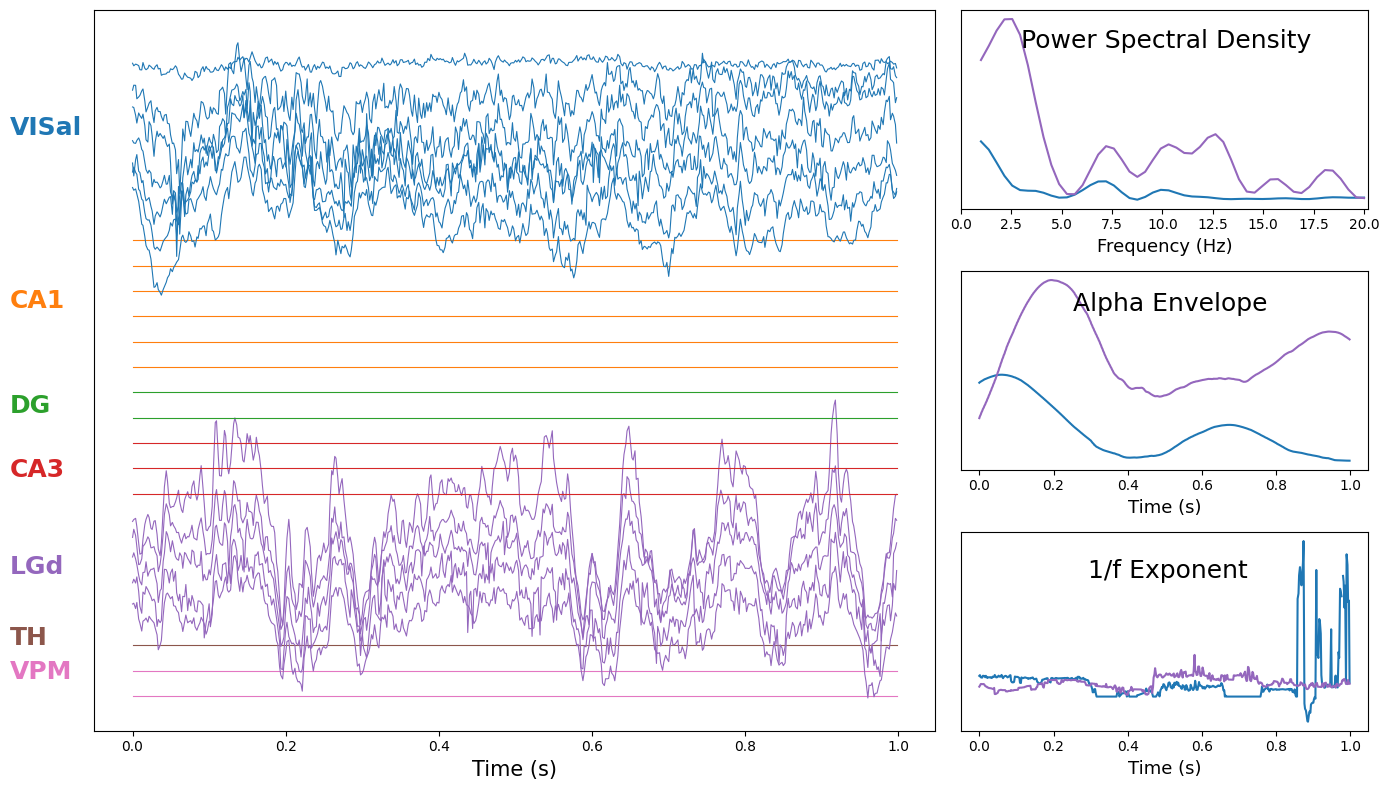

In [88]:
skip_factor = 3
fig = plt.figure(figsize=(14,8), tight_layout=True)
ax1 = plt.subplot2grid((3, 3), (0, 2), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 3), (2, 2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=2)

lfp_offset = np.arange(0, spont_lfp.shape[0]).reshape(-1,1)

lines_lfp = list()
for line_idx in range(0, spont_lfp.shape[0], skip_factor):
    # plot_lfp = ((spont_lfp[line_idx, bounds].values / np.max(spont_lfp.values))) * 30 + lfp_offset[line_idx]
    plot_lfp = ((spont_lfp[line_idx, bounds].values / np.max(spont_lfp.values))) * 30 * region_mask[line_idx] + lfp_offset[line_idx]

    temp_line = ax4.plot(plot_times, plot_lfp, linewidth=0.8, color=lfp_color_map[line_idx])
    lines_lfp.append(temp_line)

# plt.gca().invert_yaxis()
# ax4.set_yticks(region_pos, labels=region_names, fontsize=16)
_ = ax4.set_yticks([])
for name, pos in zip(region_names, region_pos):
    ax4.text(ax1.get_xlim()[1] * -0.16, pos, name, fontsize=18, color=color_dict[name], weight='bold')
    
ax4.set_xlabel('Time (s)', fontsize=15)

lines_psd_visp = ax1.plot(freqs, tfrs_visp[0, 0, :, t_idx + window_len // 2] / np.max(tfrs_visp), color=color_dict[lfp_chan_names[chan_idx_visp]])
lines_psd_lgn = ax1.plot(freqs, tfrs_lgn[0, 0, :, t_idx + window_len // 2] / np.max(tfrs_lgn), color=color_dict[lfp_chan_names[chan_idx_lgn]])

# ax1.set_ylim(0, np.max(tfrs)/2)
_ = ax1.set_yticks([])
ax1.set_xlim(0.0, 20.2)
ax1.text(3, ax1.get_ylim()[1] * 0.8, 'Power Spectral Density', fontsize=18)
ax1.set_xlabel('Frequency (Hz)', fontsize=13)

lines_envelope_visp = ax2.plot(plot_times, envelope_visp[bounds] / np.max(envelope_visp), color=color_dict[lfp_chan_names[chan_idx_visp]])
lines_envelope_lgn = ax2.plot(plot_times, envelope_lgn[bounds] / np.max(envelope_lgn), color=color_dict[lfp_chan_names[chan_idx_lgn]])

# ax2.set_ylim(0, np.max(envelope_visp))
_ = ax2.set_yticks([])
ax2.text(ax2.get_xlim()[1] * 0.24, ax2.get_ylim()[1] * 0.8, 'Alpha Envelope', fontsize=18)
ax2.set_xlabel('Time (s)', fontsize=13)


lines_exponent_visp = ax3.plot(plot_times, exponent_visp[bounds] / np.nanmax(exponent_visp), color=color_dict[lfp_chan_names[chan_idx_visp]])
lines_exponent_lgn = ax3.plot(plot_times, exponent_lgn[bounds] / np.nanmax(exponent_lgn), color=color_dict[lfp_chan_names[chan_idx_lgn]])

ax3.text(ax3.get_xlim()[1] * 0.28, ax3.get_ylim()[1] * 0.72, '1/f Exponent', fontsize=18)
ax3.set_xlabel('Time (s)', fontsize=13)
_ = ax3.set_yticks([])



In [99]:
def update_plot(plot_idx):
    bounds = range(plot_idx, plot_idx+window_len)
    plot_times = spont_times[plot_idx:plot_idx+window_len]
    
    # plot_lfp = ((spont_lfp[::skip_factor, bounds].values / np.max(spont_lfp.values))) * 30 + lfp_offset[::skip_factor]
    plot_lfp = ((spont_lfp[::skip_factor, bounds].values / np.max(spont_lfp.values))) * 30 * region_mask[::skip_factor].reshape(-1,1) + lfp_offset[::skip_factor]
    for idx, line in enumerate(lines_lfp):
        line[0].set_ydata(plot_lfp[idx,:])
    
    tfr_data_visp = tfrs_visp[0, 0, :, plot_idx + (window_len // 2)]
    lines_psd_visp[0].set_data(freqs, tfrs_visp[0, 0, :, plot_idx + (window_len // 2)] / np.max(tfrs_visp * 2))
    lines_envelope_visp[0].set_ydata(envelope_visp[bounds].squeeze() / np.max(envelope_visp * 2))
    
    tfr_data_lgn = tfrs_lgn[0, 0, :, plot_idx + (window_len // 2)]
    lines_psd_lgn[0].set_data(freqs, tfrs_lgn[0, 0, :, plot_idx + (window_len // 2)] / np.max(tfrs_lgn * 2))
    lines_envelope_lgn[0].set_ydata(envelope_lgn[bounds].squeeze() / np.max(envelope_lgn * 2))
    
    lines_exponent_visp[0].set_ydata(exponent_visp[bounds] / np.nanmax(exponent_visp))
    lines_exponent_lgn[0].set_ydata(exponent_lgn[bounds] / np.nanmax(exponent_lgn))


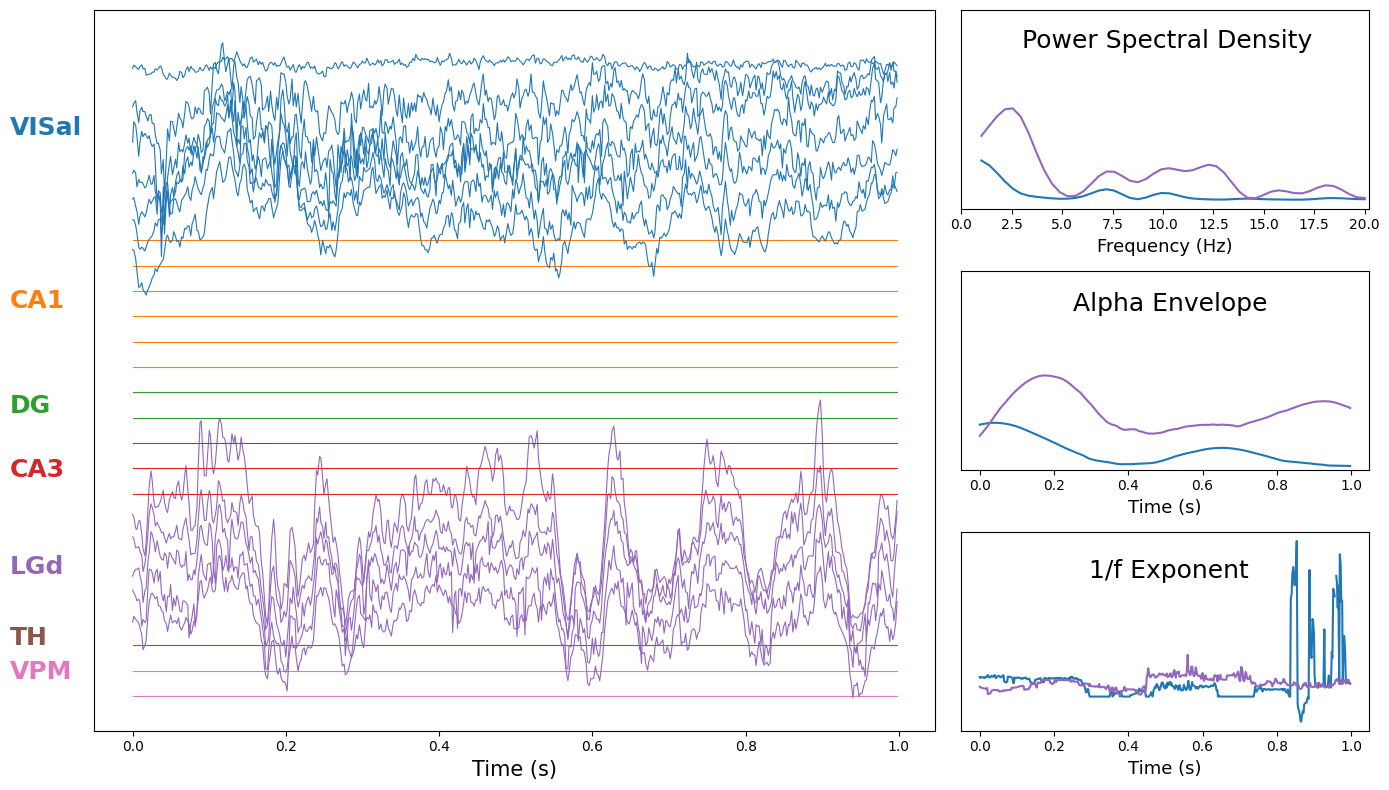

In [100]:
update_plot(10)
fig

In [ ]:
frame_start = 0
frame_stop = 20_00
decim = 5
interval = 30
fps = 30
dpi = 70
writer = 'pillow'

frames = np.arange(frame_start, frame_stop, decim)
ani = animation.FuncAnimation(
    fig, update_plot, frames, interval=interval)

writer = animation.writers[writer](fps=fps)
ani.save('../results/neuropixel_spont.gif', writer=writer, dpi=dpi)